In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, GlobalMaxPooling1D, Dropout

df = pd.read_csv('mooddata.csv')
emotions = list(df['mood'])
suggestions = list(df['sentence'])

data = []
for emotion in emotions:
    for suggestion in suggestions:
        data.append((emotion, suggestion))

np.random.shuffle(data)
vocab = set(suggestions)
X = np.zeros((len(data), len(emotions), 1))
y = np.zeros((len(data), len(vocab)))

for i, (emotion, suggestion) in enumerate(data):
    for t, token in enumerate(emotion):
        X[i, emotions.index(emotion), 0] = 1
    y[i, list(vocab).index(suggestion)] = 1

X = X / np.max(X)

model = Sequential()
model.add(Embedding(len(vocab), 32, input_length=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(vocab), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=50, batch_size=64)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(suggestions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation='softmax'))

In [ ]:
X_data = []
y_data = []

for emotion, suggestion in data:
    x_row = np.zeros((len(emotions), 1))
    x_row[emotions.index(emotion), 0] = 1
    X_data.append(x_row)

    sequence = tokenizer.texts_to_sequences([suggestion])[0]
    y_row = np.zeros((vocab_size,))
    y_row[sequence] = 1
    y_data.append(y_row)

X = np.array(X_data)
y = np.array(y_data)

In [ ]:
def data_generator(data, batch_size):
    while True:
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size]
            X_batch = np.zeros((len(batch_data), len(emotions), 1))
            y_batch = np.zeros((len(batch_data), vocab_size))
            for j, (emotion, suggestion) in enumerate(batch_data):
                X_batch[j, emotions.index(emotion), 0] = 1
                sequence = tokenizer.texts_to_sequences([suggestion])[0]
                y_batch[j, sequence] = 1
            yield X_batch, y_batch

batch_size = 64
train_generator = data_generator(data, batch_size)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit_generator(train_generator, steps_per_epoch=len(data)//batch_size, epochs=50)

In [ ]:
from tensorflow.keras.utils import get_file

glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
glove_path = get_file('glove.6B.zip', glove_url, extract=True)
glove_file = glove_path.replace('.zip', '.txt')

embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.array(values[1:], dtype=np.float32)
        embeddings_index[word] = embedding

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
import string
import nltk

df = pd.read_csv('mood_data.csv')
emotions = list(df['mood'])
labels = list(df['sentence'])
data = []

for emotion in emotions:
    for suggestion in labels:
        data.append((emotion, suggestion))

np.random.shuffle(data)

translator = str.maketrans("", "", string.punctuation)
labels = [sentence.translate(translator) for sentence in labels]
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words("english"))
labels = [" ".join([word for word in sentence.split() if word not in stop_words]) for sentence in labels]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(labels)
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(labels)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
label_mapping = {label: i for i, label in enumerate(labels)}
one_hot_labels = np.zeros((len(labels), len(labels)))

for i, label in enumerate(labels):
    one_hot_labels[i, i] = 1

In [ ]:
from sklearn.model_selection import train_test_split

max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
label_mapping = {label: i for i, label in enumerate(labels)}
one_hot_labels = np.zeros((len(labels), len(labels)))
for i, label in enumerate(labels):
    one_hot_labels[i, i] = 1

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(LSTM(64))
model.add(Dense(len(labels), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(padded_sequences, one_hot_labels, epochs=100)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
78/78 [==============================] - 3s 7ms/step - loss: 7.8291 - accuracy: 4.0551e-04
Epoch 2/100
78/78 [==============================] - 1s 7ms/step - loss: 7.8055 - accuracy: 8.1103e-04
Epoch 3/100
78/78 [==============================] - 1s 7ms/step - loss: 7.6784 - accuracy: 0.0215
Epoch 4/100
78/78 [==============================] - 1s 8ms/step - loss: 7.3689 - accuracy: 0.0608
Epoch 5/100
78/78 [==============================] - 1s 10ms/step - loss: 6.8702 - accuracy: 0.1796
Epoch 6/100
78/78 [==============================] - 1s 13ms/step - loss: 6.3248 - accuracy: 0.3646
Epoch 7/100
78/78 [==============================] - 1s 8ms/step - loss: 5.8065 - accuracy: 0.5657
Epoch 8/100
78/78 [==============================] - 1s 7ms/step - loss: 5.3174 - accuracy: 0.6772
Epoch 9/100
78/78 [==============================] - 1s 8ms/step - loss: 4.8667 - accuracy: 0.7534
Epoch 10/100
78/78 [==============================] - 1s 10ms/step - loss: 4.4365 - accuracy: 0.785

In [ ]:
history = model.fit(padded_sequences, one_hot_labels, epochs=40)
accuracy_values = history.history['accuracy']

Epoch 1/40
78/78 [==============================] - 3s 6ms/step - loss: 0.0337 - accuracy: 0.9834
Epoch 2/40
78/78 [==============================] - 1s 7ms/step - loss: 0.0327 - accuracy: 0.9858
Epoch 3/40
78/78 [==============================] - 1s 7ms/step - loss: 0.0327 - accuracy: 0.9854
Epoch 4/40
78/78 [==============================] - 1s 7ms/step - loss: 0.0332 - accuracy: 0.9842
Epoch 5/40
78/78 [==============================] - 1s 7ms/step - loss: 0.0312 - accuracy: 0.9846
Epoch 6/40
78/78 [==============================] - 1s 7ms/step - loss: 0.0302 - accuracy: 0.9854
Epoch 7/40
78/78 [==============================] - 1s 9ms/step - loss: 0.0295 - accuracy: 0.9858
Epoch 8/40
78/78 [==============================] - 1s 9ms/step - loss: 0.0291 - accuracy: 0.9850
Epoch 9/40
78/78 [==============================] - 1s 7ms/step - loss: 0.0294 - accuracy: 0.9846
Epoch 10/40
78/78 [==============================] - 1s 7ms/step - loss: 0.0286 - accuracy: 0.9862
Epoch 11/40
78/78 [

In [ ]:
mean_accuracy = np.mean(accuracy_values)
mean_accuracy

0.9853000819683075

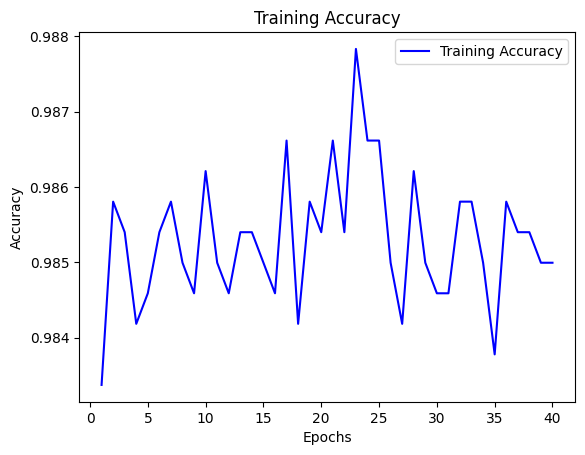

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

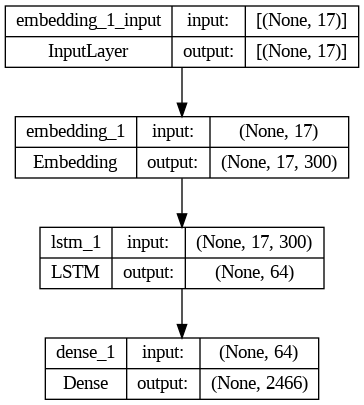

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 300)           755700    
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 2466)              160290    
                                                                 
Total params: 1009430 (3.85 MB)
Trainable params: 253730 (991.13 KB)
Non-trainable params: 755700 (2.88 MB)
_________________________________________________________________


In [ ]:
def generate_suggestions(model, tokenizer, data, labels, input_mood, num_suggestions):
    input_sequence = tokenizer.texts_to_sequences([input_mood])
    padded_input = pad_sequences(input_sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_input)
    top_predicted_indices = np.argsort(prediction, axis=1)[0][-num_suggestions:][::-1]
    suggested_sentences = [data[index][1] for index in top_predicted_indices]
    return suggested_sentences

input_mood = "sadness"
suggestion = generate_suggestions(model, tokenizer,data, labels, input_mood, 3)
suggestion = suggestion[1]
print(f"You sound like you're struggling with sadness, {suggestion}")

input_mood = "anger"
suggestionss = generate_suggestions(model, tokenizer,data, labels, input_mood, 3)
suggestion = suggestionss[2]
print(f"You sound like you're struggling with anger, {suggestion}")

input_mood = "anger"
suggestionss = generate_suggestions(model, tokenizer,data, labels, input_mood, 3)
suggestion = suggestionss[1]
print(f"You sound like you're struggling with fear,  {suggestion}")

1/1 [==============================] - 0s 30ms/step
You sound like you're struggling with sadness, Visualize people and things that bring you comfort, calm and peace. soak up the good feelings.
1/1 [==============================] - 0s 19ms/step
You sound like you're struggling with anger, Here's a tip for you appreciate even minor blessings like clean water, a roof overhead or being able to walk independently. gratitude shifts perspective.
1/1 [==============================] - 0s 18ms/step
You sound like you're struggling with fear,  If you fear you are in immediate danger,remain aware of your surroundings at all times. watch for escape routes and potential weapons.
